In [79]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os

plt.style.use('fivethirtyeight')

In [80]:
path = r'C:\Users\iryna\Documents\11.08.2024 Boat Sales Analysis'

In [81]:
boats_2 = pd.read_csv(os.path.join(path,'02 Data','Prepared Data', 'sub1.csv'))

In [82]:
boats_2.head()

,Unnamed: 0,Year Built,Length,Width,Number of views last 7 days,value_in_eur,clusters,cluster
0,0,2017,4.00,1.90,226,3337.0,0,light pink
1,1,2020,4.00,1.50,75,3490.0,0,light pink
2,2,0,3.69,1.42,124,3770.0,0,light pink
3,3,2020,3.00,1.00,64,3367.0,0,light pink
4,4,2019,3.55,1.46,58,3399.0,0,light pink


In [83]:
# Dropping 0 values in column 'Year Built' to be able to apply datetime format='%Y'

boats2 = boats_2[boats_2['Year Built'].ne(0)]


In [84]:
boats2.head()

,Unnamed: 0,Year Built,Length,Width,Number of views last 7 days,value_in_eur,clusters,cluster
0,0,2017,4.00,1.90,226,3337.0,0,light pink
1,1,2020,4.00,1.50,75,3490.0,0,light pink
3,3,2020,3.00,1.00,64,3367.0,0,light pink
4,4,2019,3.55,1.46,58,3399.0,0,light pink
6,6,1999,6.20,2.38,474,3600.0,0,light pink


In [85]:
# Changing the 'Year Built' column to datetime format 

boats2['Year Built'] = pd.to_datetime(boats2['Year Built'], format='%Y')

C:\Users\iryna\AppData\Local\Temp\ipykernel_20396\2810734614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boats2['Year Built'] = pd.to_datetime(boats2['Year Built'], format='%Y')


In [86]:
# Creating a subset with only the 'Year Built' and mean 'value_in_eur' column for further analysis

boats2_grouped = boats2.groupby('Year Built').agg({'value_in_eur':['mean']})

In [87]:
boats2_grouped.isnull().sum() 

value_in_eur  mean    0
dtype: int64

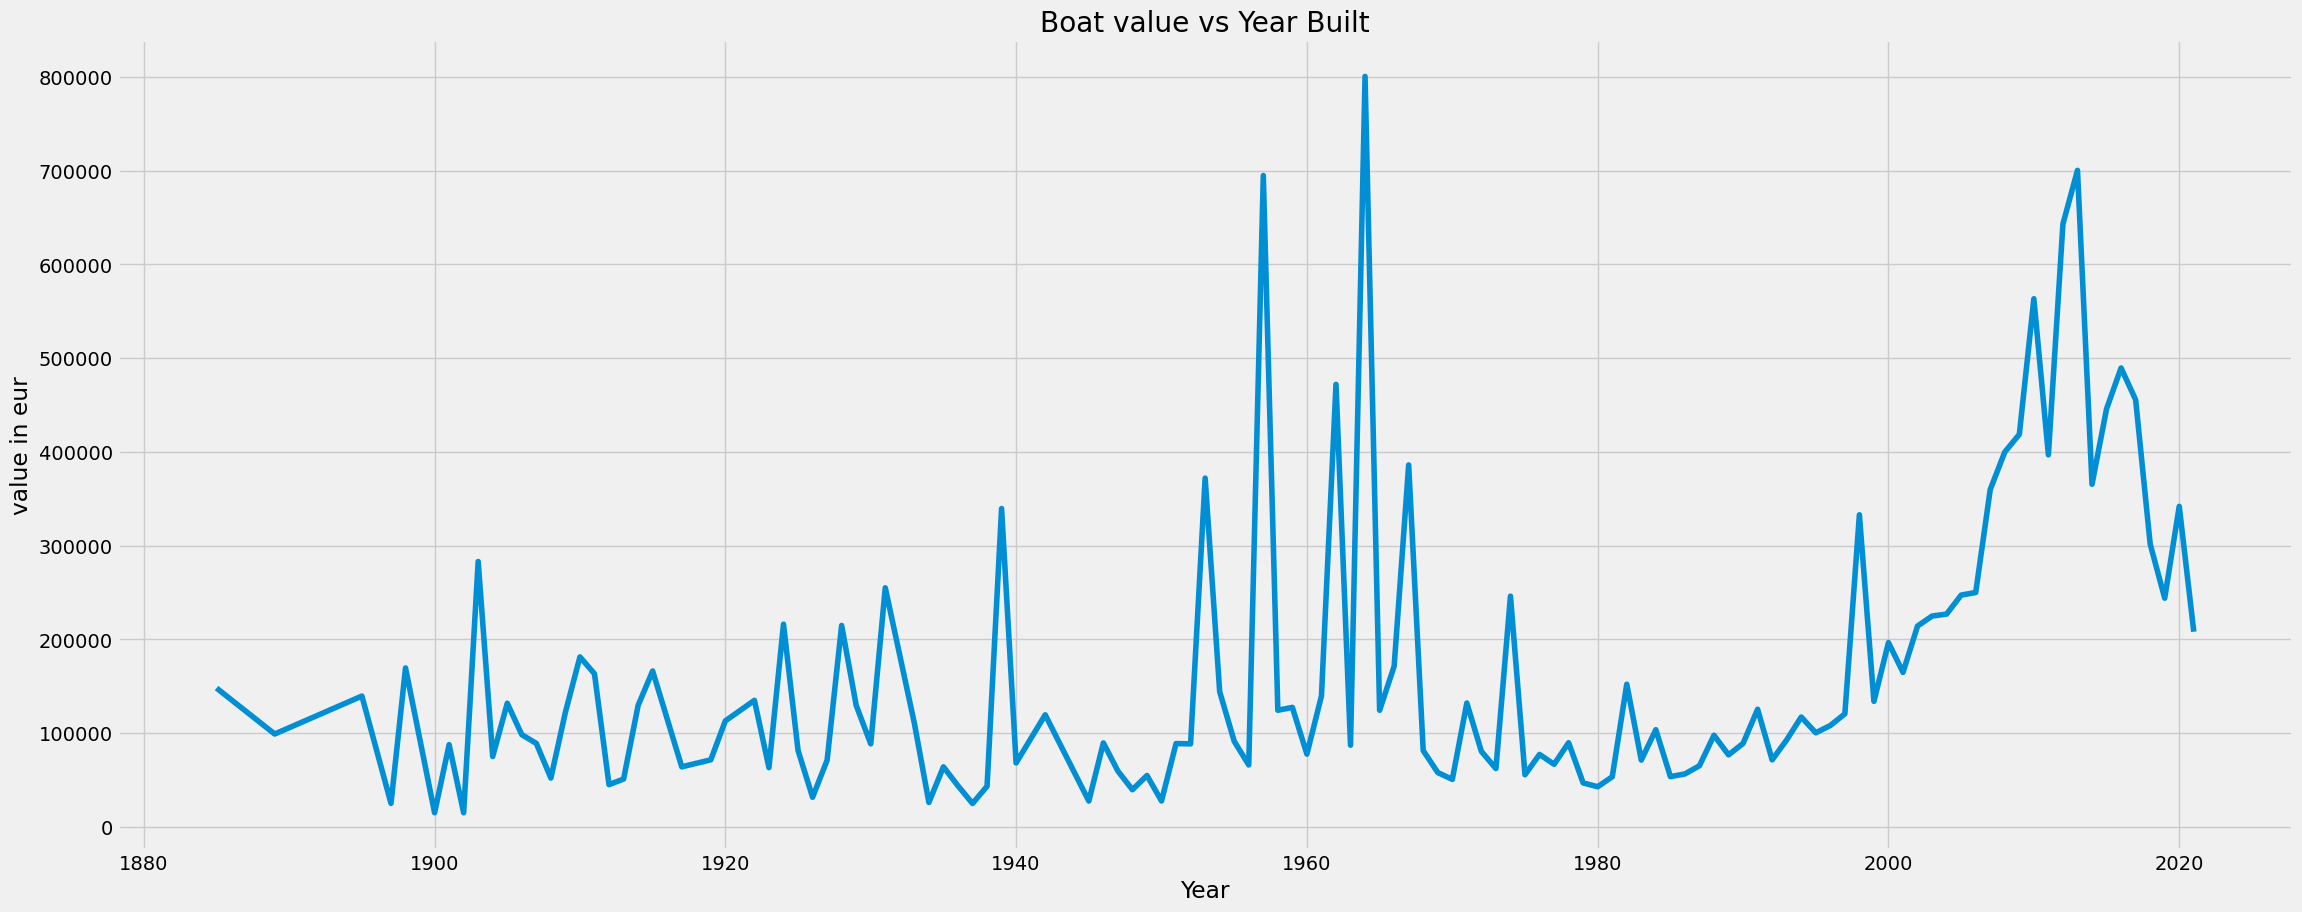

In [88]:
plt.figure(figsize=(25,10), dpi=100) 
plt.title('Boat value vs Year Built')
plt.xlabel('Year')
plt.ylabel('value in eur')
plt.plot(boats2_grouped)

#### The graph shows big jumps of the boat values ​​for 1950 -1970 years, we also see an upward trend after at 2000 year, which drops at 2010-2020 years.

In [89]:
# Decomposing the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(boats2_grouped, model='additive', period=4)

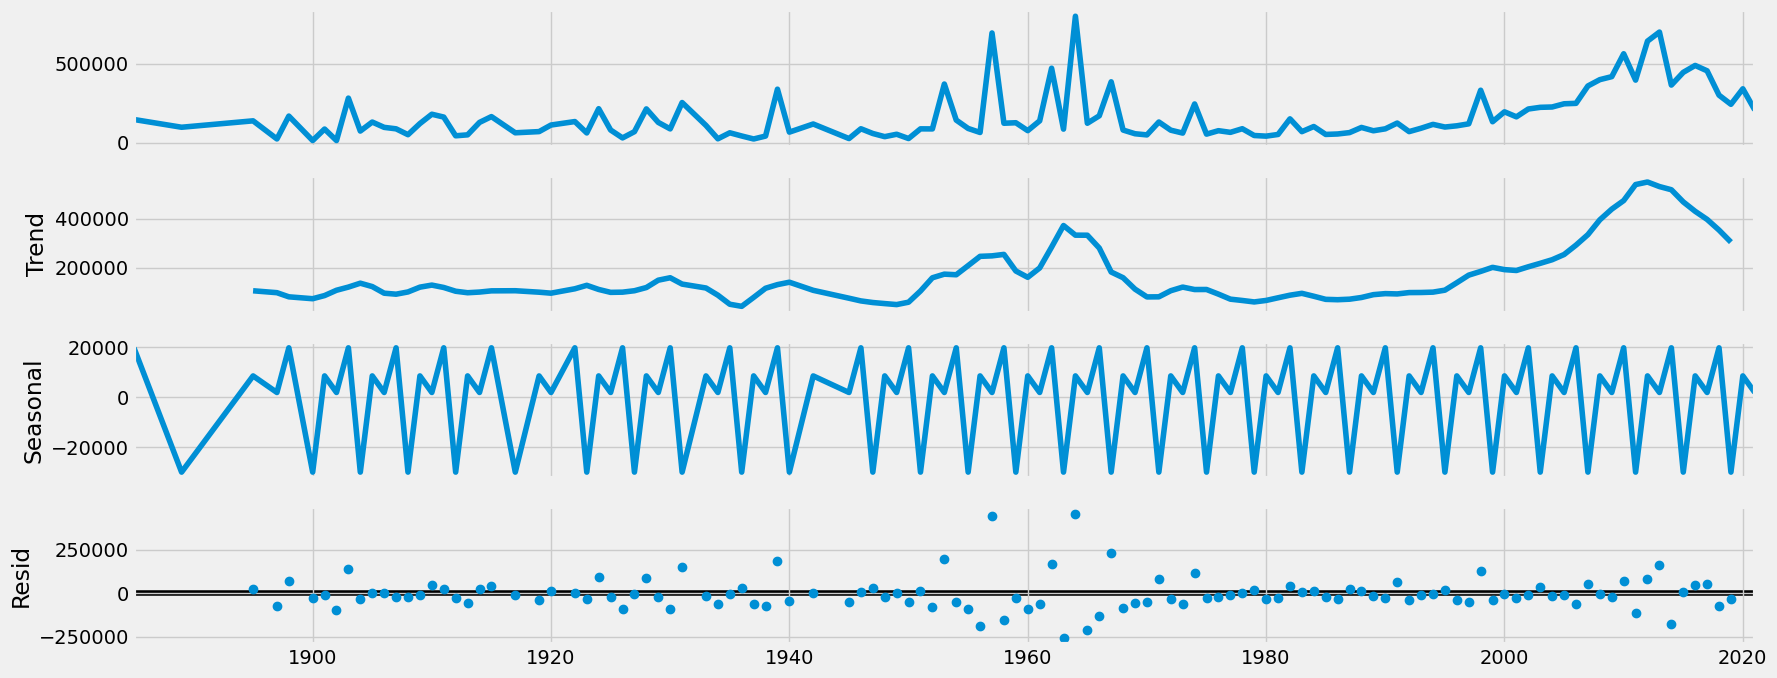

In [90]:
# Defining a fixed size for all special charts.

from pylab import rcParams 

rcParams['figure.figsize'] = 18, 7

decomposition.plot()
plt.show()

#### Trend chart after removing the noise looks smoother, you can now see the trends more clearly, especially in the years 1950-1970.
#### Seasonal chart has a sharp curve (data has seasonality). If the data had no seasonality, the curve would be flat.
#### Resid chart does not show much noise.

In [104]:
# Importing the adfuller() function

from statsmodels.tsa.stattools import adfuller 

# Performing the Dickey-Fuller test:

def dickey_fuller(timeseries): 
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)
    
# Applying the test using the function on the time series

dickey_fuller(boats2_grouped['value_in_eur'])


Dickey-Fuller Stationarity test:
Test Statistic                  -2.042781
p-value                          0.268136
Number of Lags Used             11.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64


#### p-value is 0.268136 (>0.05)
#### A “significant” result would be a p-value < 0.05.

#### Critical Value (5%) is -2.888697
#### Test Statistic is -2.042781

#### The null hypothesis would be the presence of a unit root (no unit root = stationary data = can proceed with forecast)
#### Test Statistic (-2.042781) > Critical Value (5%) (-2.888697)
### Null hypothesis can not be rejected (present unit root)
### Data is non-stationary


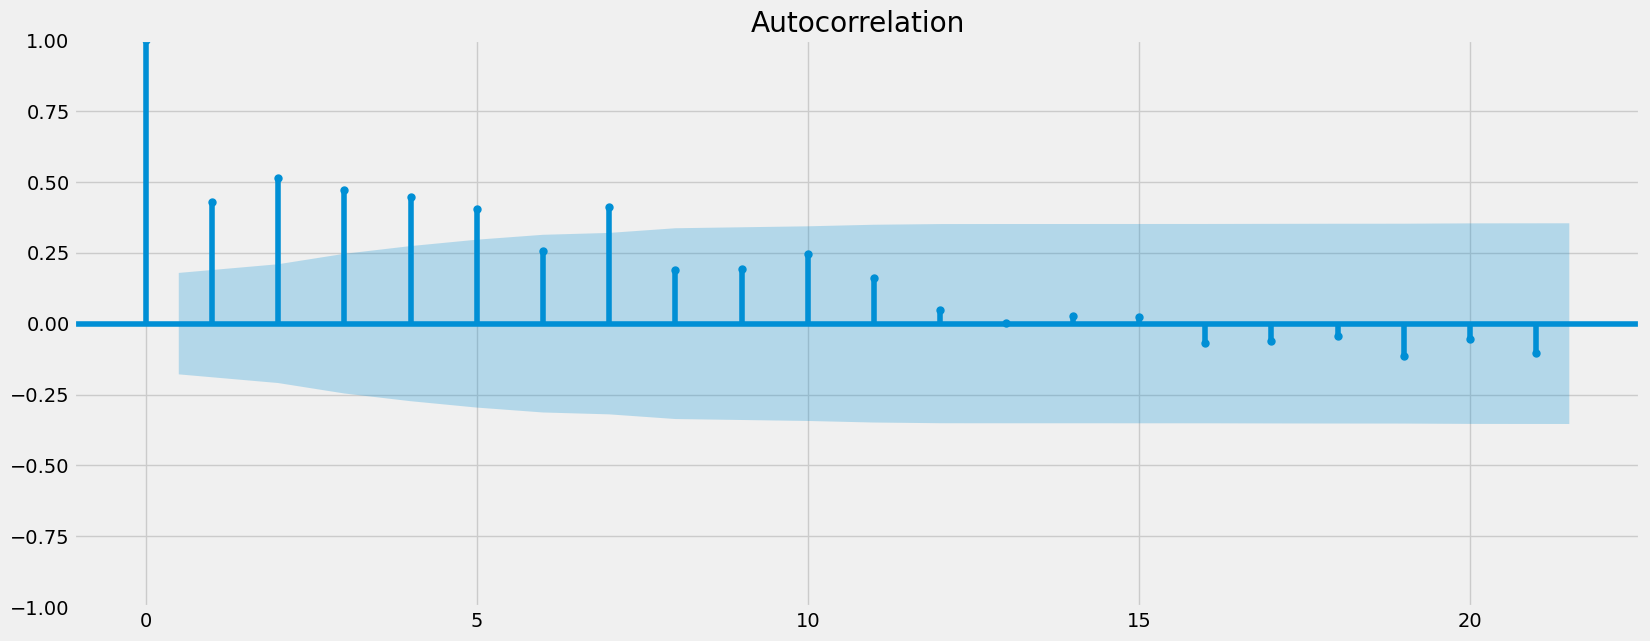

In [111]:
# Importing the autocorrelation and partial correlation plots

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

# Checking a plot of autocorrelation

plot_acf(boats2_grouped)
plt.show()

#### Can see lines go above the blue edge of the confidence interval, this means we have lags that are significantly correlated with each other. Also we have many lags beyond this interval, so can deduce that the data is non-stationary (has a trend).


## Stationarizing Time Series Data

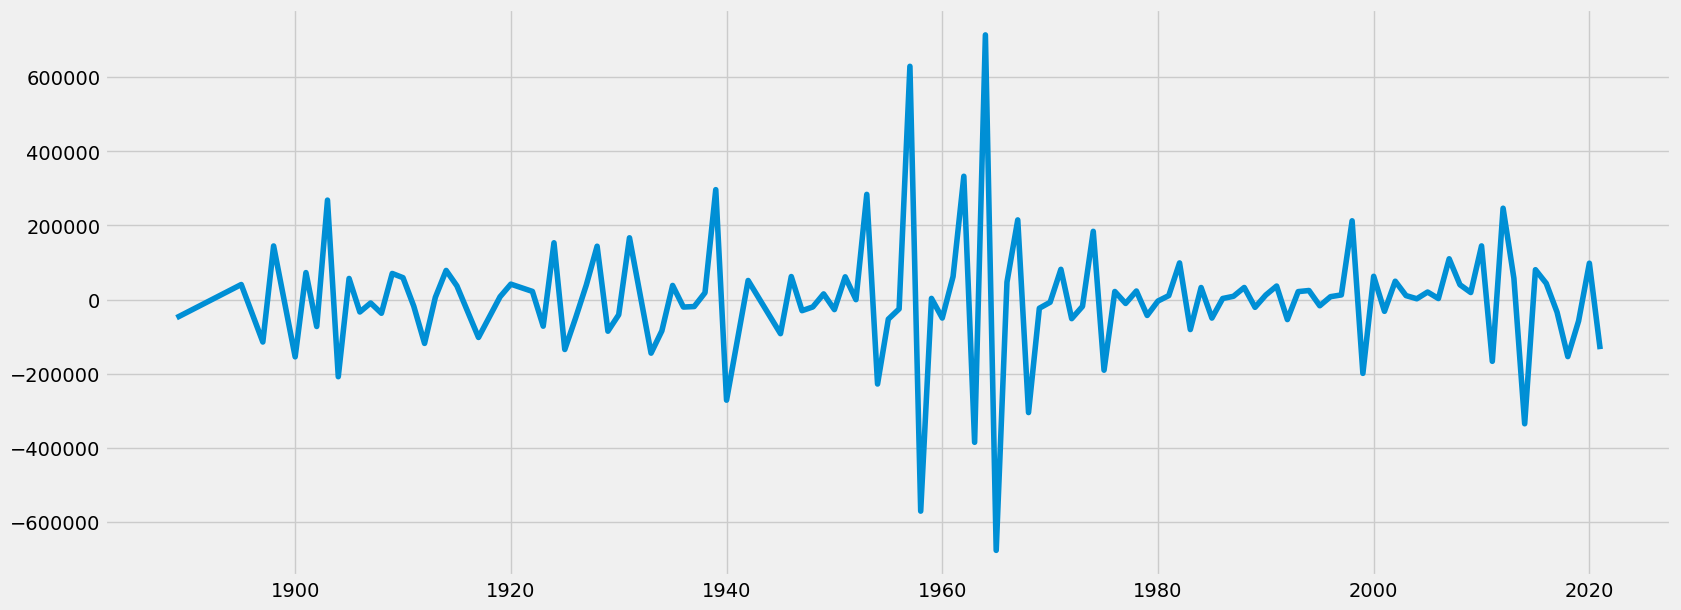

In [115]:
boats3st_diff = boats2_grouped - boats2_grouped.shift(1)
boats3st_diff.dropna(inplace = True)

plt.figure(figsize=(18,7), dpi=100)
plt.plot(boats3st_diff)

#### The curve on the graph in the 1960s has smaller fluctuations (only up to 600,000), and a significant decrease in fluctuations at 2000-2020 years is also visible. 

In [117]:
# Applying the test using the function on the time series

dickey_fuller(boats3st_diff)


Dickey-Fuller Stationarity test:
Test Statistic                -6.210303e+00
p-value                        5.528514e-08
Number of Lags Used            5.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


#### Test Statistic (-6.210303e+00) < Critical Value (5%) (-2.887477e+00)
### Null hypothesis can not be rejected
### Data is stationary


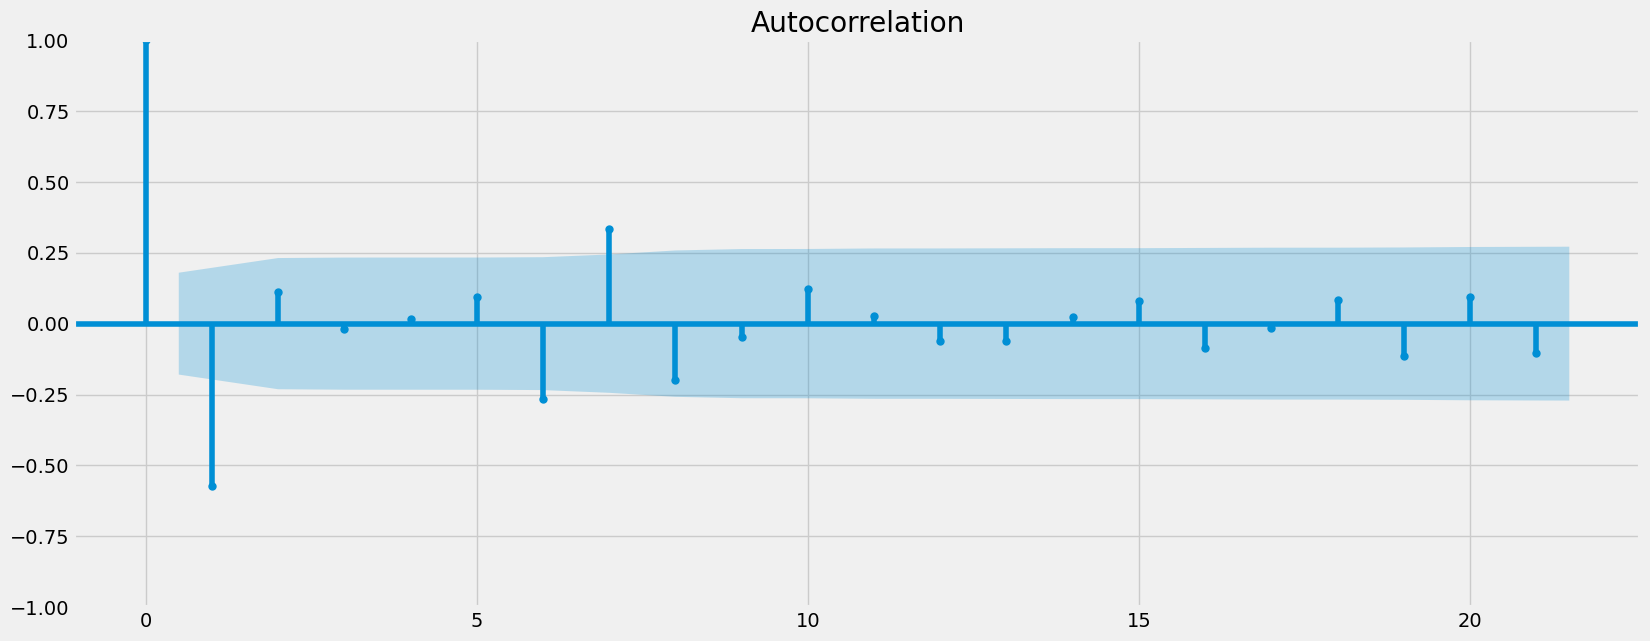

In [121]:
# Checking a plot of autocorrelation

plot_acf(boats3st_diff)
plt.show()

#### There are still some of lines (lags) above the blue confidence interval. Stationarity is weak (despite the Dickey-Fuller test saying that data is stationary)